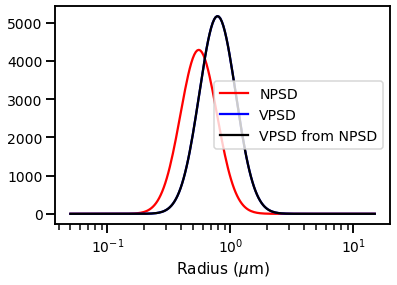

In [5]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os.path, time

"""
functions
"""


def lognormaldist(Dp,CMD,GSD,N): #Dp: particles diameters, CMD: count median diameter, GSD: geometric std, N: total number concentration
    n = (N/(np.sqrt(2*np.pi)*(np.log(GSD))))*np.exp(-(np.log(Dp)-np.log(CMD))**2/(2*(np.log(GSD)**2)))    
    return n


def itegrate_pf(P11, angle):
    
    delta_t = np.pi/180
    int_P11 = 2*np.pi*np.sum(P11*np.sin(angle*np.pi/180))*delta_t
    
    return int_P11

def VPSD_conv(NPSD_, R_PSD_):
    VPSD_=NPSD_*np.pi*4/3*(R_PSD_)**3
    
    #VPSD = pd.DataFrame({'N':V_all, 'D':(PSD['D'].values)})
    return VPSD_

degree_sign = u'\N{DEGREE SIGN}'


sns.set_context('talk', font_scale = 0.85)

"""
import data
"""

###
#grasp_data_path = os.path.normpath(r'\\fs03\SONATA\MoallemiOnly\Aerosol Angular Scattering\project_3_ML\latin_hyper_cube_sampling_unimodal')
grasp_data_path = '/data/project/general/aerosolretriev/aerosol_data/raw_data'
grasp_cases = pd.read_csv(grasp_data_path+'/GRASP_LHS_rand_paremeters.csv')
grasp_data = pd.read_csv(grasp_data_path+'/ML_simulated_scat_data.csv')

"""
"""

# select a random test case for GRASP data
index = 2107#34#108
angles = np.arange(0,180)

para_test = grasp_cases.iloc[index] 
PF_test = grasp_data.iloc[index] 
PF_532nm = PF_test.loc[['P11_0.532_'+str(i) for i in angles]].values


# volume PSD factors
GSD_ = para_test['GSD']
r_V = para_test['R_median']
V_tot = para_test['V_tot']

sigma = np.log(GSD_)
mu_V = np.log(r_V)

# number size distribution factors accoding to Grainger document
mu_ = mu_V - 3*(sigma**2) 
r_N = np.exp(mu_)
N_tot = V_tot/(4/3*np.pi*np.exp(3*mu_+4.5*sigma**2))
r_GRASP = np.logspace(np.log(0.05), np.log(15), 200, base=np.e)


"""
check the number distribution vs volume distribution
"""

# get the number distribution
N_log_norm = lognormaldist(r_GRASP,r_N,GSD_,N_tot)

# get the GRASP distribution
V_log_norm = lognormaldist(r_GRASP,r_V,GSD_,V_tot)

# volume distribution from number distribution
V_log_norm_ = VPSD_conv(np.array(N_log_norm), r_GRASP)

figure = plt.figure()

plt.plot(r_GRASP, N_log_norm, color = 'red', label = 'NPSD')
plt.plot(r_GRASP, V_log_norm, color = 'blue', label = 'VPSD')
plt.plot(r_GRASP, V_log_norm_, color = 'k', label = 'VPSD from NPSD')

plt.xscale('log')
plt.xlabel(r'Radius ($\mu$m)')
plt.legend()


"""
Scattering calculations
"""

# number concentartion per size bin
N_per_bin = N_log_norm*(np.log(r_GRASP[1]/r_GRASP[0]))
Dp_array_in = 2*np.array(r_GRASP)*1e-6 


m = para_test['n_532nm']+ 1j*para_test['k_532nm']
wavelength = 532 #nm

sigma_list = []
S11_list = []



In [6]:
import PyMieScatt as ps

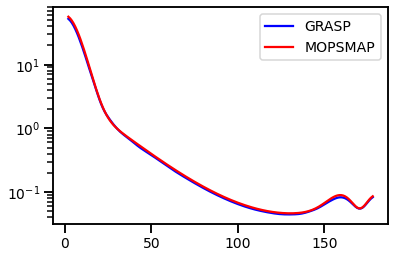

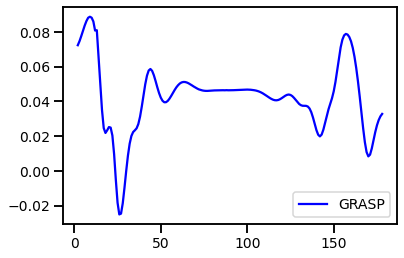

In [7]:
# clauclate S11 and Qscat for each sizes in the size bin
for dia_i in Dp_array_in:
    
    dia_i_ = dia_i*1e9 #nm
    
    results = ps.ScatteringFunction(m, wavelength, dia_i_, nMedium=1.0, minAngle=0, maxAngle=180, angularResolution=1)
    sigmas_ = ps.MieQ(m, wavelength, dia_i_, asDict=True, asCrossSection=True)
    sigma_list.append(sigmas_['Csca']*1e-14)# cc
    S11_list.append(results[3])
    

# beta_per_size = np.array(sigma_list)*N_per_bin 
S11_list_array = np.array(S11_list) 
angles_ = np.round(results[0]*180/np.pi)
df_S11 = pd.DataFrame(S11_list_array, columns = angles_)
P11_ = df_S11.multiply(N_per_bin, axis = 0).sum() #multiple S11 by number concentartion and take the sum to get phase function P11


#define data frames of results
df_data_GRASP = pd.DataFrame({'angles':angles,'data':(PF_532nm)})
df_data_pyMie = pd.DataFrame({'angles':angles_,'data':P11_})

df_data_GRASP=df_data_GRASP[(df_data_GRASP['angles']>1) & (df_data_GRASP['angles']<179)]
df_data_pyMie=df_data_pyMie[(df_data_pyMie['angles']>1) & (df_data_pyMie['angles']<179)]

df_data_GRASP.index = df_data_GRASP['angles'].values
df_data_GRASP.index = df_data_GRASP['angles'].values


"""
plot results
"""
figure, ax = plt.subplots()


ax.plot(df_data_GRASP['angles'], df_data_GRASP['data']/df_data_GRASP['data'][30], color = 'blue', label = 'GRASP')
plt.plot(df_data_GRASP['angles'], df_data_pyMie['data']/df_data_pyMie['data'][30], label = 'MOPSMAP', color = 'r')
#ax.plot(df_PF['angle'], df_PF['P11']/df_PF['P11'][30], color = 'b', label = 'Mie')

ax.set_yscale('log')
ax.legend()


figure, ax = plt.subplots()

GRASP = df_data_GRASP['data']/df_data_GRASP['data'][30]
PyMie = df_data_pyMie['data']/df_data_pyMie['data'][30]

err = (PyMie-GRASP)/PyMie

ax.plot(df_data_GRASP['angles'], err, color = 'blue', label = 'GRASP')
ax.legend()




In [9]:
err.mean()

0.0423693231497917

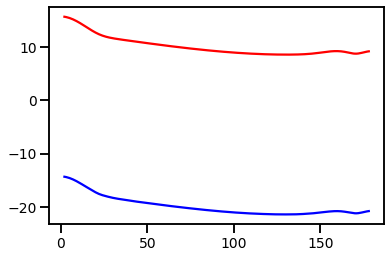

In [12]:
"""
plot results
"""
figure, ax = plt.subplots()


ax.plot(df_data_GRASP['angles'], np.log(df_data_GRASP['data']), color = 'blue', label = 'GRASP')
plt.plot(df_data_GRASP['angles'], np.log(df_data_pyMie['data']), label = 'MOPSMAP', color = 'r')
#ax.plot(df_PF['angle'], df_PF['P11']/df_PF['P11'][30], color = 'b', label = 'Mie')


In [10]:
df_data_GRASP

angles          data
2         2  5.885400e-07
3         3  5.536400e-07
4         4  5.092300e-07
5         5  4.587700e-07
6         6  4.056100e-07
..      ...           ...
174     174  7.219700e-10
175     175  7.785600e-10
176     176  8.380700e-10
177     177  8.937500e-10
178     178  9.391100e-10

[177 rows x 2 columns]

In [13]:
df_data_pyMie

angles          data
2.0       2.0  6.170619e+06
3.0       3.0  5.819378e+06
4.0       4.0  5.369364e+06
5.0       5.0  4.853663e+06
6.0       6.0  4.305311e+06
...       ...           ...
174.0   174.0  7.182296e+03
175.0   175.0  7.776691e+03
176.0   176.0  8.397153e+03
177.0   177.0  8.974859e+03
178.0   178.0  9.443825e+03

[177 rows x 2 columns]